In [1]:
import os
import shutil
from itertools import islice
import requests

import pandas as pd
import matplotlib.pyplot as plt

import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql import functions as F
from pyspark.sql.types import *
import re
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer,  IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row
!pip uninstall nltk -y
!pip install nltk
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Create spark_session
spark = SparkSession.builder.getOrCreate()
conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '32g'), ('spark.app.name', 'Spark Updated Conf'), 
                                        ('spark.executor.cores', '32'), ('spark.cores.max', '32'), ('spark.driver.memory','32g')])
spark.sparkContext.getConf().getAll()

from IPython.display import clear_output
clear_output(wait = False)

spark.version

import time
start_time = time.time()

In [2]:
from google.cloud import storage

In [3]:
%%time
df = spark.read.parquet('gs://msca-bdp-students-bucket/shared_data/jasmeetsingh/df_final_for_analysis_with_entity/')
df = df.filter("retweeted_status is null and tweet_text is not null and text is not null")

df.count()

22/12/07 18:51:30 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


CPU times: user 50.4 ms, sys: 20.7 ms, total: 71.1 ms
Wall time: 1min 23s


318991

In [4]:
df.limit(5).toPandas()

,created_at,id,geo_coordinates,user_name,followers_count,verified_user,user_location,user_description,reply_count,retweet_count,retweeted_status,tweet_text,text,entity
0,Thu Jun 16 13:32:30 +0000 2022,1537427899984363520,None,Greg Leech,55,False,None,Anti-communist. National Divorce advocate. Hai...,NaN,NaN,None,@theHappyMedic @Wayne_Razzi @KurtSchlichter Gr...,@thehappymedic @wayne_razzi @kurtschlichter gr...,Others
1,Thu Jun 16 13:32:46 +0000 2022,1537427967252365313,None,FireballBen1776🇺🇸🇺🇸🇺🇸,508,False,Florida,FJB,NaN,NaN,None,@jaxdotcom People should get there kids away f...,@jaxdotcom people should get there kids away f...,Influencer
2,Thu Jun 16 13:32:47 +0000 2022,1537427971157262338,None,Real estate magnate,800,False,somewhere in the world,proudly Igbo // serial entrepreneur// real est...,NaN,NaN,None,@Morris_Monye When the average professor in th...,@morris_monye when the average professor in th...,Influencer
3,Thu Jun 16 13:35:23 +0000 2022,1537428626597203969,None,Chris Still Masking Ward,803,False,Minneapolis,"java, javascript, robots, developer, hacker, h...",NaN,NaN,None,@zacharywefel And yet when I say MPLS schools ...,@zacharywefel and yet when i say mpls schools ...,School and Universities
4,Thu Jun 16 13:35:44 +0000 2022,1537428716657074177,None,Tim M,9,False,None,None,NaN,NaN,None,@AllIDoI42240688 @madeinusaonly @GovRonDeSanti...,@allidoi42240688 @madeinusaonly @govrondesanti...,Others


In [5]:
def get_tokens(df):
    return df\
        .map( lambda document: re.sub(r'[^a-zA-Z0-9 ]', '', document))\
        .map( lambda document: document.strip().lower())\
        .map( lambda document: re.split(" ", document))\
        .map( lambda word: [x for x in word if len(x) >= 2] )\
        .map( lambda word: [x for x in word if x not in StopWords])\
        .zipWithIndex()

In [6]:
def to_DF(rdd_, col):    
    row = Row(col)
    return rdd_.map(row).zipWithIndex().toDF([col, 'id'])

def token_cleaning(tokens):
    df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])
    df_tokens = df_tokens.where(col('list_of_words').getItem(0).isNotNull())
    return df_tokens

In [7]:
mh = MinHashLSH(inputCol = "features", outputCol = "hashes", numHashTables = 5)
def get_df_hashed(df_vectorize):
    model = mh.fit(df_vectorize)
    df_hashed = mh.fit(df_vectorize).transform(df_vectorize)
    return model, df_hashed

In [8]:
def getJaccardBarChart(df, jaccard_distance, model):

    df_dups_text = model.approxSimilarityJoin(
                        df, df, jaccard_distance
                    ).filter("datasetA.id < datasetB.id").select(
                        col("distCol"),
                        col("datasetA.id").alias("id_A"),
                        col("datasetB.id").alias("id_B"),
                        col("datasetA.tweet_text").alias('text_A'),
                        col("datasetB.tweet_text").alias('text_B')
                    )

    df_dups_text.cache()
    df_dups_text.limit(5).toPandas()
    
    records = df.count()
    dups = df_dups_text.select('id_A').distinct().count()
    uniques = records - dups
    
    clear_output(wait = True)
    
    return df_dups_text, records, dups

In [9]:
df_tweets_main = df.select(['tweet_text', 'entity'])

In [10]:
ets = df_tweets_main.groupby('entity').agg(count('*')).toPandas()
display(ets)
entity = list(df_tweets_main.groupby('entity').agg(count('*')).toPandas().entity)

,entity,count(1)
0,Nonprofit Organizations,759
1,Government,10918
2,Influencer,76504
3,School and Universities,13083
4,Others,186183
5,News,31544


In [11]:
print(entity)

['Nonprofit Organizations', 'Government', 'Influencer', 'School and Universities', 'Others', 'News']


In [12]:
StopWords = stopwords.words("english")

def run_similarity(i, fraction_filter, complete = None):
    if(complete == None):
        part_to_analyse = df_tweets_main.filter("entity == '" + i + "'")
        part_to_analyse = part_to_analyse.sample(fraction = fraction_filter, seed = 42)
    else:
        part_to_analyse = df_tweets_main
        part_to_analyse = part_to_analyse.sample(fraction = fraction_filter, seed = 42)
    
    part_to_analyse = part_to_analyse.cache()
    tweets = part_to_analyse.rdd.map(lambda x : x['tweet_text'])

    global StopWords
    text_tokens = get_tokens(tweets)

    df_tweets = to_DF(tweets, 'tweet_text')
    df_tweets_tokens = token_cleaning(text_tokens)

    vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
    df_tweets_tokens_vectorized = vectorize.fit(df_tweets_tokens).transform(df_tweets_tokens)

    model, df_hashed= get_df_hashed(df_tweets_tokens_vectorized)

    df_hashed_text_joined = df_tweets.join(df_hashed, "id", how = 'left')

    df_hashed_text_joined = df_hashed_text_joined.\
                                where(size(df_hashed_text_joined.list_of_words) >= 5)

    text_dups_list = []
    df_dups_text_20, records, dups = getJaccardBarChart(df_hashed_text_joined, 0.2, model)
    text_dups_list.append([records, dups, records - dups, 0.2])

    df_dups_text_40, records, dups = getJaccardBarChart(df_hashed_text_joined, 0.4, model)
    text_dups_list.append([records, dups, records - dups, 0.4])

    df_dups_text_50, records, dups = getJaccardBarChart(df_hashed_text_joined, 0.5, model)
    text_dups_list.append([records, dups, records - dups, 0.5])

    df_dups_text_60, records, dups = getJaccardBarChart(df_hashed_text_joined, 0.6, model)
    text_dups_list.append([records, dups, records - dups, 0.6])

    df_dups_text_70, records, dups = getJaccardBarChart(df_hashed_text_joined, 0.7, model)
    text_dups_list.append([records, dups, records - dups, 0.7])

    df_ = pd.DataFrame(text_dups_list, columns = ['counts', 'dups', 'unique', 'threshold'])
    df_.plot(x = 'threshold', y = ['unique','dups'], kind = 'bar', title = i)
    plt.show()
    return text_dups_list

In [13]:
summarized_similarity = []

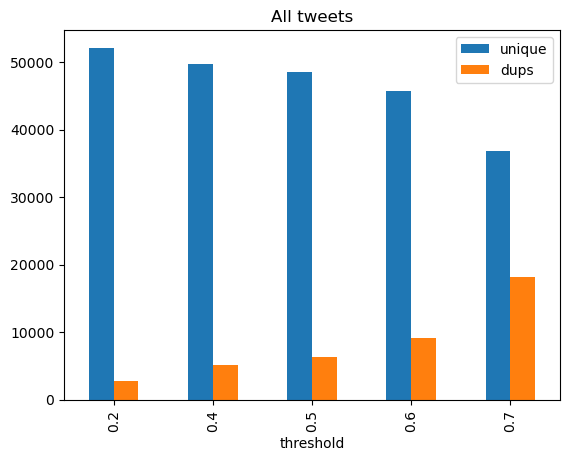

In [ ]:
summarized_similarity.append(run_similarity("All tweets", 0.175, complete = True))

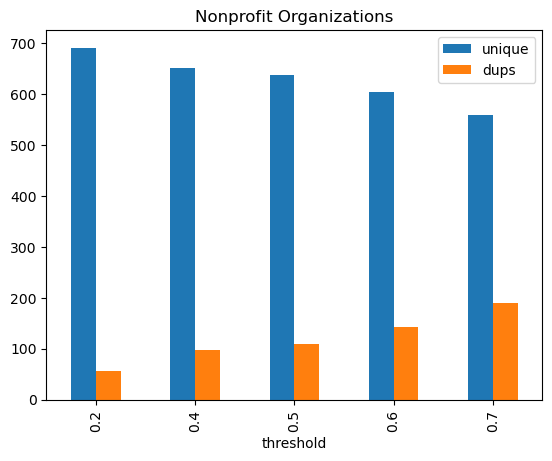

In [ ]:
summarized_similarity.append(run_similarity('Nonprofit Organizations', 1.0))

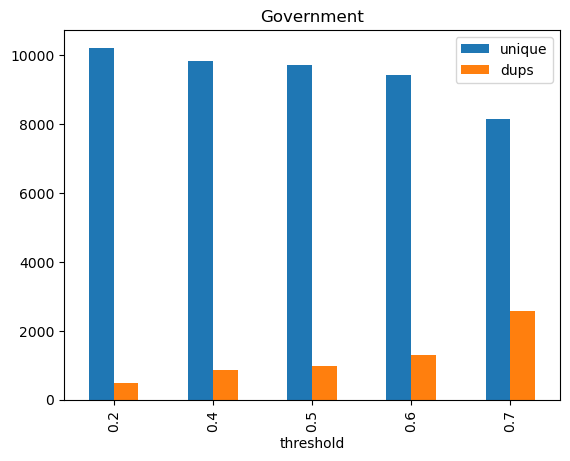

In [ ]:
summarized_similarity.append(run_similarity('Government', 1.0))

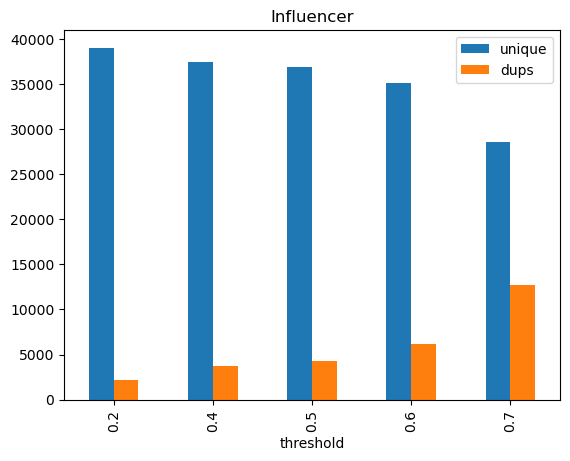

In [ ]:
summarized_similarity.append(run_similarity('Influencer', 0.55))

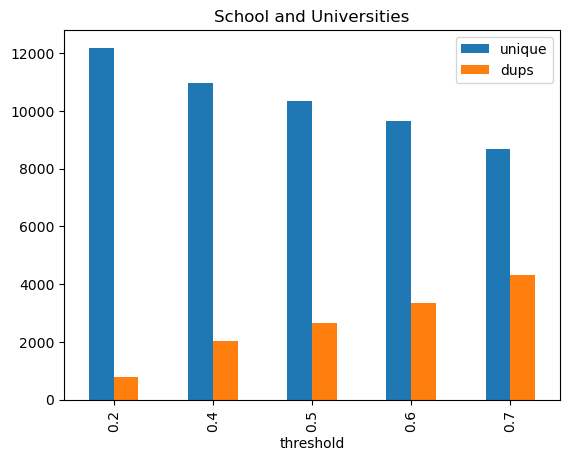

In [ ]:
summarized_similarity.append(run_similarity('School and Universities', 1.0))

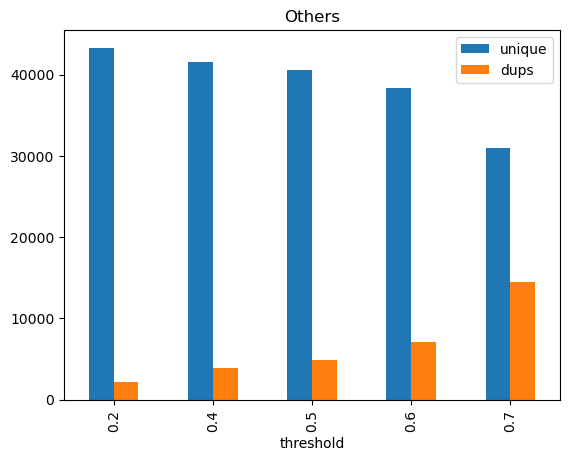

In [ ]:
summarized_similarity.append(run_similarity('Others', 0.25))

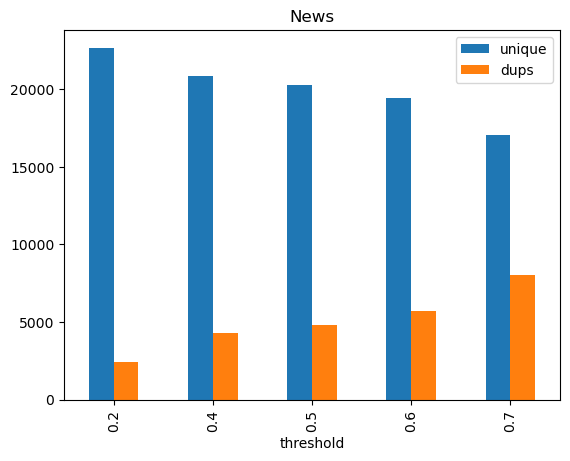

In [ ]:
summarized_similarity.append(run_similarity('News', 0.8))

In [ ]:
entity.insert(0, "All Tweets")
print(entity)
count = 0
for i in summarized_similarity:
    for j in i:
        j.append(entity[count])
    count += 1
summarized_similarity

['All Tweets', 'Nonprofit Organizations', 'Government', 'Influencer', 'School and Universities', 'Others', 'News']


[[[54890, 2746, 52144, 0.2, 'All Tweets'],
  [54890, 5167, 49723, 0.4, 'All Tweets'],
  [54890, 6299, 48591, 0.5, 'All Tweets'],
  [54890, 9179, 45711, 0.6, 'All Tweets'],
  [54890, 18136, 36754, 0.7, 'All Tweets']],
 [[747, 56, 691, 0.2, 'Nonprofit Organizations'],
  [747, 97, 650, 0.4, 'Nonprofit Organizations'],
  [747, 110, 637, 0.5, 'Nonprofit Organizations'],
  [747, 143, 604, 0.6, 'Nonprofit Organizations'],
  [747, 189, 558, 0.7, 'Nonprofit Organizations']],
 [[10705, 481, 10224, 0.2, 'Government'],
  [10705, 856, 9849, 0.4, 'Government'],
  [10705, 988, 9717, 0.5, 'Government'],
  [10705, 1285, 9420, 0.6, 'Government'],
  [10705, 2568, 8137, 0.7, 'Government']],
 [[41195, 2155, 39040, 0.2, 'Influencer'],
  [41195, 3732, 37463, 0.4, 'Influencer'],
  [41195, 4321, 36874, 0.5, 'Influencer'],
  [41195, 6127, 35068, 0.6, 'Influencer'],
  [41195, 12675, 28520, 0.7, 'Influencer']],
 [[12986, 797, 12189, 0.2, 'School and Universities'],
  [12986, 2040, 10946, 0.4, 'School and Universi

In [ ]:
summarized_similarity_rows = []

In [ ]:
for i in summarized_similarity:
    for j in i:
        summarized_similarity_rows.append(j)

In [ ]:
similarity_df = pd.DataFrame(summarized_similarity_rows, columns = ['records', 'duplicates', 'unique', 'jaccard_threshold', 'organization'])

In [ ]:
similarity_df['average_duplicates_ratio'] = similarity_df['duplicates']/similarity_df['records']

In [ ]:
similarity_df = similarity_df[['jaccard_threshold', 'average_duplicates_ratio', 'organization']]

In [ ]:
summarized_similarity

[[[54890, 2746, 52144, 0.2, 'All Tweets'],
  [54890, 5167, 49723, 0.4, 'All Tweets'],
  [54890, 6299, 48591, 0.5, 'All Tweets'],
  [54890, 9179, 45711, 0.6, 'All Tweets'],
  [54890, 18136, 36754, 0.7, 'All Tweets']],
 [[747, 56, 691, 0.2, 'Nonprofit Organizations'],
  [747, 97, 650, 0.4, 'Nonprofit Organizations'],
  [747, 110, 637, 0.5, 'Nonprofit Organizations'],
  [747, 143, 604, 0.6, 'Nonprofit Organizations'],
  [747, 189, 558, 0.7, 'Nonprofit Organizations']],
 [[10705, 481, 10224, 0.2, 'Government'],
  [10705, 856, 9849, 0.4, 'Government'],
  [10705, 988, 9717, 0.5, 'Government'],
  [10705, 1285, 9420, 0.6, 'Government'],
  [10705, 2568, 8137, 0.7, 'Government']],
 [[41195, 2155, 39040, 0.2, 'Influencer'],
  [41195, 3732, 37463, 0.4, 'Influencer'],
  [41195, 4321, 36874, 0.5, 'Influencer'],
  [41195, 6127, 35068, 0.6, 'Influencer'],
  [41195, 12675, 28520, 0.7, 'Influencer']],
 [[12986, 797, 12189, 0.2, 'School and Universities'],
  [12986, 2040, 10946, 0.4, 'School and Universi

In [ ]:
final_df = []
for i in summarized_similarity:
    row = []
    org = i[0][-1]
    row.append(org)
    records = i[0][0]
    row.append(records)
    for j in i:
        row.append(j[1])
        row.append(j[2])
        row.append(j[3])
    final_df.append(row)

In [ ]:
final_df[0]

['All Tweets',
 54890,
 2746,
 52144,
 0.2,
 5167,
 49723,
 0.4,
 6299,
 48591,
 0.5,
 9179,
 45711,
 0.6,
 18136,
 36754,
 0.7]

In [ ]:
df_plot = pd.DataFrame(final_df, columns = ['Organizations', 'records', '% of duplicates at Jaccard Threshold of 0.2', 'unique_0.2', 'threshold_1',
                                                                       '% of duplicates at Jaccard Threshold of 0.4', 'unique_0.4', 'threshold_2',
                                                                       '% of duplicates at Jaccard Threshold of 0.5', 'unique_0.5', 'threshold_3',
                                                                       '% of duplicates at Jaccard Threshold of 0.6', 'unique_0.6', 'threshold_4',
                                                                       '% of duplicates at Jaccard Threshold of 0.7', 'unique_0.7', 'threshold_5'])

In [ ]:
df_plot = df_plot.set_index(keys = 'Organizations', drop = True)
for i in df_plot.columns:
    if('Jaccard' in i):
        try:
            df_plot[i] = df_plot[i]/df_plot['records']
        except:
            pass
        
df_plot.drop(columns = ['records', 'threshold_1', 'threshold_2', 'threshold_3', 'threshold_4', 'threshold_5', 
                       'unique_0.2', 'unique_0.4', 'unique_0.5', 'unique_0.6', 'unique_0.7'], inplace = True)

df_plot = df_plot.round({'Jaccard Threshold of 0.2': 2, 
                         'Jaccard Threshold of 0.4': 2, 
                         'Jaccard Threshold of 0.5': 2, 
                         'Jaccard Threshold of 0.6': 2, 
                         'Jaccard Threshold of 0.7': 2})
df_plot

,% of duplicates at Jaccard Threshold of 0.2,% of duplicates at Jaccard Threshold of 0.4,% of duplicates at Jaccard Threshold of 0.5,% of duplicates at Jaccard Threshold of 0.6,% of duplicates at Jaccard Threshold of 0.7
Organizations,,,,,
All Tweets,0.050027,0.094134,0.114757,0.167225,0.330406
Nonprofit Organizations,0.074967,0.129853,0.147256,0.191432,0.253012
Government,0.044932,0.079963,0.092293,0.120037,0.239888
Influencer,0.052312,0.090594,0.104891,0.148732,0.307683
School and Universities,0.061374,0.157092,0.203142,0.256507,0.332050
Others,0.046827,0.086062,0.106527,0.156874,0.318876
News,0.096531,0.170125,0.192346,0.227072,0.320298


In [ ]:
import seaborn as sns
sns.set_style("dark")
plt.rcParams["figure.figsize"] = (10, 4)
entity_analysis.sort_values(by = 'count(id)', inplace = True, ascending = False)
display(entity_analysis)
fig = entity_analysis.plot(kind='barh', legend=None, color= 'deepskyblue', grid = True)
fig.set_xlabel('Number of Tweets per Entity')
fig.set_ylabel('Organization (User Type)')
fig.set_yticklabels(entity_analysis.entity)
fig.bar_label(fig.containers[0], fmt = '%d', label_type='edge')
plt.ticklabel_format(style='plain', axis='x')
plt.xticks(rotation = 0)
plt.xlim([-5, 2000000])
plt.show()

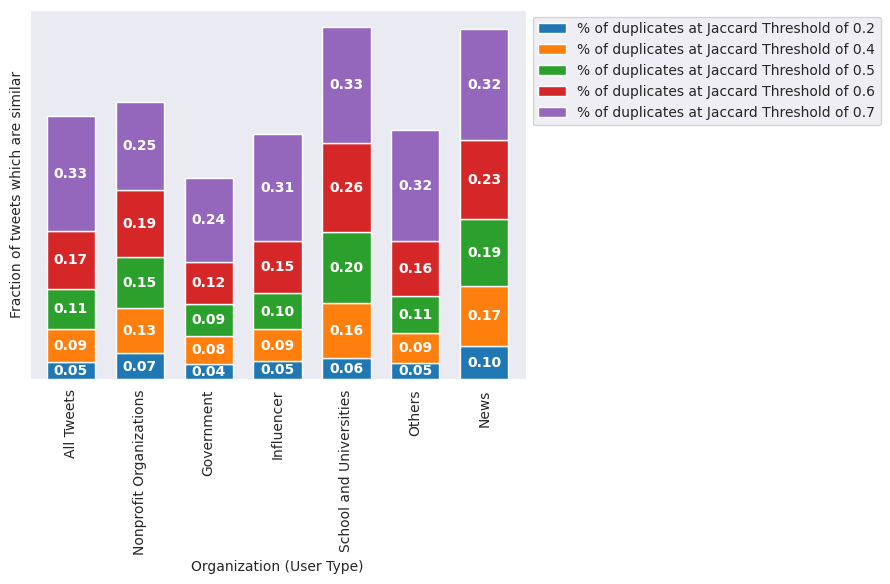

In [57]:
import seaborn as sns
sns.set_style("dark")
plt.figure.figsize = (100, 50)
fig = df_plot.plot.bar(width = 0.7, stacked = True)
fig.set_ylabel('Fraction of tweets which are similar')
fig.set_xlabel('Organization (User Type)')
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.tick_params( axis='y', which='both', left = False, 
                 labelleft = False, labelbottom = False
               )
for x in fig.containers:
    fig.bar_label(x, label_type='center', fmt = '%1.2f', weight = 'bold', color='white')
plt.show()

In [ ]:
print("--- Total Time to run the notebook: %s seconds ---" % (time.time() - start_time))

--- Total Time to run the notebook: 7333.280586719513 seconds ---
